In [2]:
!pip install datasets
from datasets import load_dataset

# -----------------------------
# BLOCK 1: Load & Prep Dataset
# -----------------------------
dataset_raw = load_dataset("Scuccorese/food-ingredients-dataset", split="train")
print(f"Loaded {len(dataset_raw)} samples.")

# Only a small pool to reduce memory load
POOL_SIZE = 400
dataset_full = list(dataset_raw.take(POOL_SIZE))
IMG_SIZE = (96, 96)  # slightly larger for better features

Loaded 6676 samples.


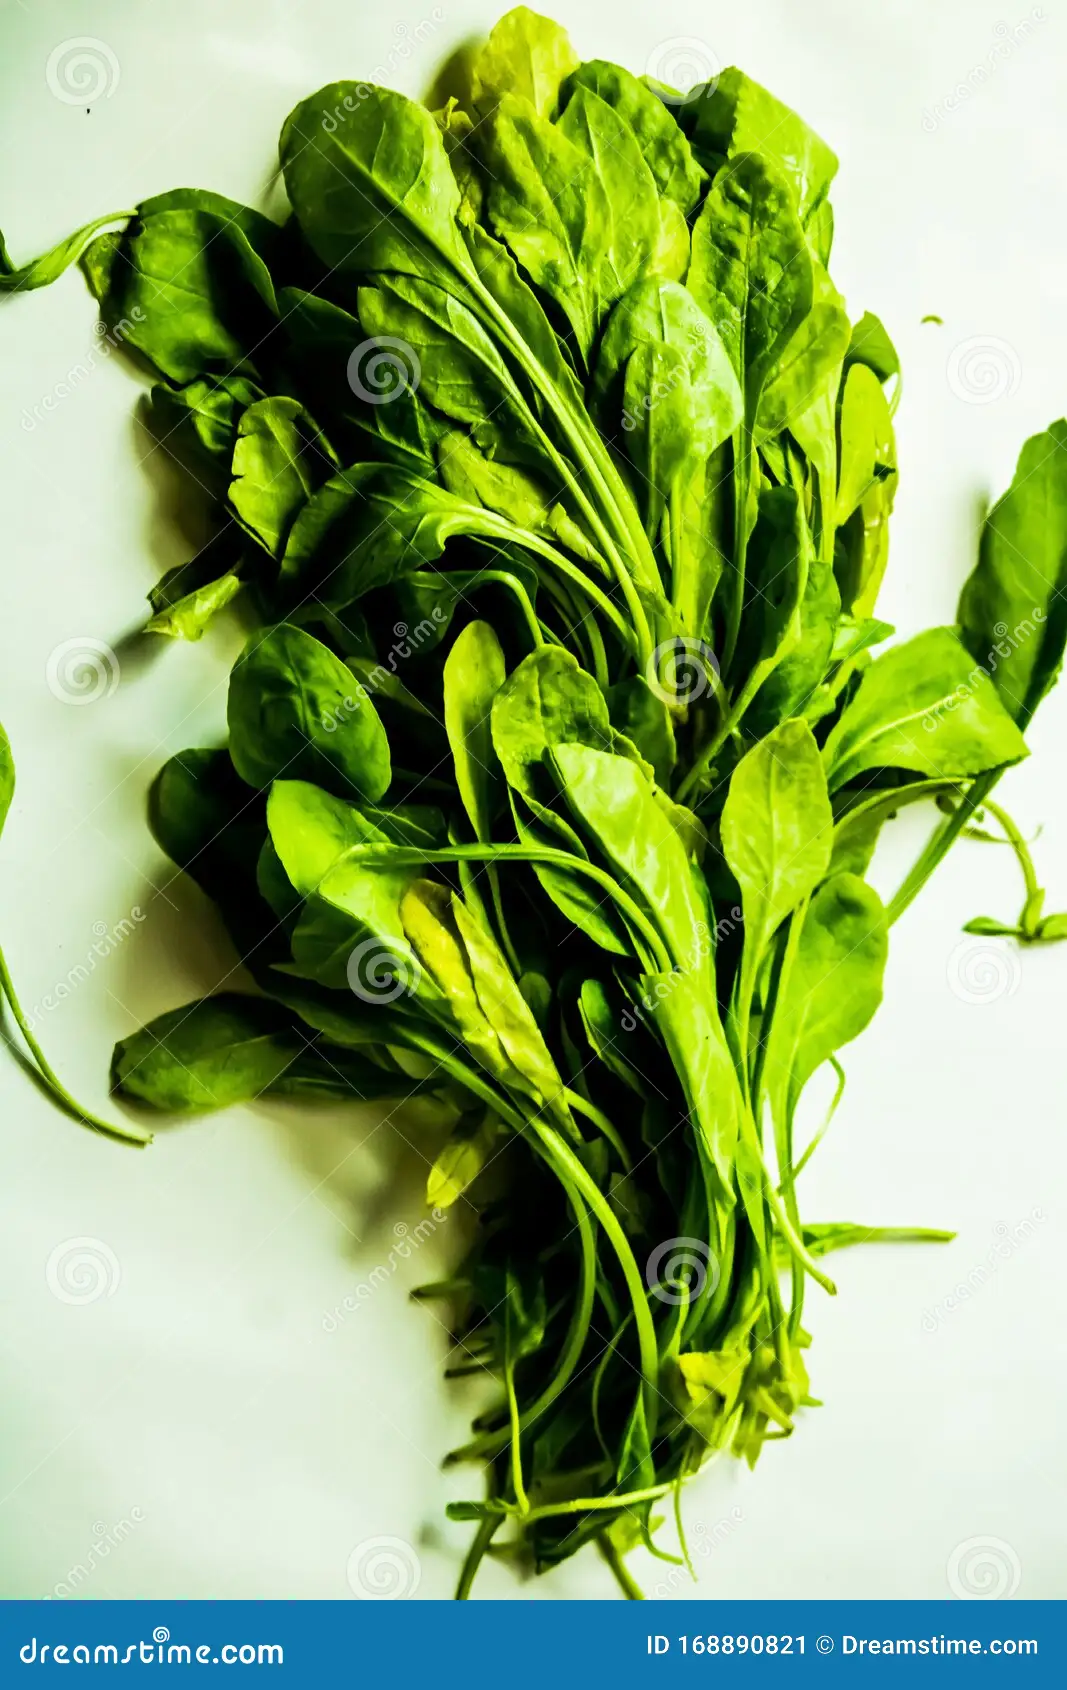

leafy


In [3]:
from PIL import Image
for i in range(1):
  img = dataset_raw[i]['image']
  display(img)
  print(dataset_raw[i]['subcategory'])

In [4]:
# -----------------------------
# BLOCK 3: Discover Label Space
# -----------------------------
unique_labels = set()
for sample in dataset_full:
    subs = sample["subcategory"]
    if isinstance(subs, str):
        unique_labels.add(subs)
    elif isinstance(subs, list):
        unique_labels.update(subs)

label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
num_classes = len(label_to_idx)
print(f"Found {num_classes} unique subcategories.")

Found 3 unique subcategories.


In [5]:
from PIL import Image
import numpy as np, random, math, tensorflow as tf

POOL_SIZE = 400          # safe pool of original images
dataset_full = list(dataset_raw.take(POOL_SIZE))
IMG_SIZE = (64, 64)
TOTAL_SAMPLES = 300      # total synthetic images to pre-generate

synthetic_imgs = []
synthetic_labels = []

def create_collage(indices, cell_size=(64,64), max_grid=(3,3)):
    imgs, labels = [], []
    for i in indices:
        sample = dataset_full[i]
        img = sample["image"].convert("RGB").resize(cell_size)
        imgs.append(np.array(img, dtype=np.uint8))
        subs = sample["subcategory"]
        labels.extend([subs] if isinstance(subs, str) else subs)
    n = len(imgs)
    cols = min(n, max_grid[1])
    rows = math.ceil(n / cols)
    collage_h = rows * cell_size[1]
    collage_w = cols * cell_size[0]
    collage = np.ones((collage_h, collage_w, 3), dtype=np.uint8) * 255
    for idx, im in enumerate(imgs):
        r, c = divmod(idx, cols)
        y0, y1 = r*cell_size[1], (r+1)*cell_size[1]
        x0, x1 = c*cell_size[0], (c+1)*cell_size[0]
        collage[y0:y1, x0:x1, :] = im
    collage_pil = Image.fromarray(collage)
    collage_resized = np.array(collage_pil.resize(IMG_SIZE), dtype=np.float32)/255.0
    label_vec = np.zeros(num_classes, dtype=np.float32)
    for s in labels:
        idx = label_to_idx.get(s)
        if idx is not None:
            label_vec[idx] = 1.0
    return collage_resized, label_vec

# Pre-generate synthetic dataset
for _ in range(TOTAL_SAMPLES):
    n_ing = random.randint(3, 8)
    idxs = random.sample(range(len(dataset_full)), n_ing)
    img, lbl = create_collage(idxs)
    synthetic_imgs.append(img)
    synthetic_labels.append(lbl)

synthetic_imgs = np.array(synthetic_imgs, dtype=np.float32)
synthetic_labels = np.array(synthetic_labels, dtype=np.float32)

# 70/30 split
split_idx = int(TOTAL_SAMPLES * 0.7)
train_imgs, test_imgs = synthetic_imgs[:split_idx], synthetic_imgs[split_idx:]
train_labels, test_labels = synthetic_labels[:split_idx], synthetic_labels[split_idx:]

# Build TF datasets
tf_train = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
tf_test  = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Pre-generated {TOTAL_SAMPLES} synthetic multi-ingredient images")
print(f"Train batches: {len(train_imgs)//32}, Test batches: {len(test_imgs)//32}")


Pre-generated 300 synthetic multi-ingredient images
Train batches: 6, Test batches: 2


In [6]:
# -----------------------------
# BLOCK 5: Define Model (Fine-tuning top layers)
# -----------------------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping

base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")

# --- Fine-tune top layers ---
base_model.trainable = True
for layer in base_model.layers[:100]:  # freeze first 100 layers
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

class AccPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}: Train acc={logs['binary_accuracy']:.4f} | Val acc={logs['val_binary_accuracy']:.4f}")

early_stop = EarlyStopping(monitor="val_binary_accuracy", patience=3, restore_best_weights=True)


/tmp/ipython-input-2557473861.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")


In [7]:
# -----------------------------
# BLOCK 6: Train Model (Improved)
# -----------------------------
print("\n🚀 Training PantryPal (multi-ingredient, 70/30 split, fine-tuned)...\n")

history = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=15,             # train longer for fine-tuning
    callbacks=[AccPrinter(), early_stop]
)


🚀 Training PantryPal (multi-ingredient, 70/30 split, fine-tuned)...

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - binary_accuracy: 0.4854 - loss: 0.9703
Epoch 1: Train acc=0.5016 | Val acc=0.5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - binary_accuracy: 0.4874 - loss: 0.9684 - val_binary_accuracy: 0.5000 - val_loss: 0.7500
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - binary_accuracy: 0.5807 - loss: 0.8001
Epoch 2: Train acc=0.5873 | Val acc=0.5333
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - binary_accuracy: 0.5815 - loss: 0.8002 - val_binary_accuracy: 0.5333 - val_loss: 0.7404
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - binary_accuracy: 0.6321 - loss: 0.7127
Epoch 3: Train acc=0.6238 | Val acc=0.5481
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - binary_accuracy: 0.6311 - loss: 0.7138 - val_binary_accuracy: 0.5481 - val_loss: 0.7277
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - binary_accuracy: 0.6433 - loss: 0.6610
Epoch 4: Train acc=0.6317 | Val acc=0.5593
7/7 ━━

In [8]:
# -----------------------------
# BLOCK 7: Final Results
# -----------------------------
train_acc = history.history['binary_accuracy'][-1]
test_acc  = history.history['val_binary_accuracy'][-1]
print(f"\n✅ Training complete — Train acc={train_acc:.4f}, Test acc={test_acc:.4f}")


✅ Training complete — Train acc=0.8302, Test acc=0.6963


In [9]:
model.save("PantryPal_FineTuned.h5")


In [10]:
from google.colab import files
files.download("PantryPal_FineTuned.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>